In [1]:
%matplotlib widget
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.signal import find_peaks

# 设置中文字体为 wqy
plt.rcParams['font.sans-serif'] = ['WenQuanYi Zen Hei']  # 使用文泉驿正黑字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [16]:
def calculate_threshold(red_channel, mask = None):
    if mask is not None:
        red_channel = cv.bitwise_and(red_channel, red_channel, mask=mask)
    hist = cv.calcHist([red_channel], [0], None, [256], [0, 256]).flatten()
    hist[0] = 0
    peaks, _ = find_peaks(hist)
    sorted_peaks = sorted(peaks, key=lambda x: hist[x], reverse=True)
    second_peak_index = sorted_peaks[1]
    min_val_after_peak = np.argmin(hist[second_peak_index:]) + second_peak_index
    return min_val_after_peak


def segment_image(src, threshold, kernel_size):
    _, src_bin = cv.threshold(src, threshold, 255, cv.THRESH_BINARY)
    kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)
    src_bin = cv.morphologyEx(src_bin, cv.MORPH_OPEN, kernel)
    src_bin = cv.morphologyEx(src_bin, cv.MORPH_CLOSE, kernel)
    coords = cv.findNonZero(src_bin)
    contours, _ = cv.findContours(src_bin, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours:
        return cv.boundingRect(coords), None
    contour = max(contours, key=cv.contourArea)
    mask = np.zeros(src.shape, dtype=np.uint8)
    cv.drawContours(mask, [contour], -1, 1, thickness=cv.FILLED)
    return cv.boundingRect(coords), mask


def crop_to_bbox(frame, bbox):
    x, y, w, h = bbox
    return frame[y : y + h, x : x + w]


def read_frame(video_path, frame_number):
    cap = cv.VideoCapture(video_path)
    cap.set(cv.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    if not ret:
        raise ValueError(f"Could not read frame {frame_number}")
    return frame


def process_frame(frame, kernel_size=(9, 9)):
    red_channel = frame[:, :, 2]
    threshold = calculate_threshold(red_channel)

    bbox, mask = segment_image(red_channel, threshold, (5, 5))
    red_channel = crop_to_bbox(red_channel, bbox)
    mask = crop_to_bbox(mask, bbox)

    threshold = calculate_threshold(red_channel, mask)
    _, binary_image = cv.threshold(red_channel, threshold, 255, cv.THRESH_BINARY_INV)

    kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)
    processed_image = cv.morphologyEx(binary_image, cv.MORPH_OPEN, kernel)
    processed_image = cv.morphologyEx(processed_image, cv.MORPH_CLOSE, kernel)

    edges = cv.Canny(processed_image, 50, 150)
    contours, _ = cv.findContours(edges, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)

    min_length = 500  # 设置最小长度阈值
    max_radius = min(bbox[2:]) // 2
    max_area = np.pi * (max_radius ** 2)
    circularity_threshold = 0.5 # 设置圆形度阈值

    # 在 cropped_frame 上绘制过滤后的轮廓
    cropped_frame = crop_to_bbox(frame, bbox)

    for contour in contours:
        area = cv.contourArea(contour)
        perimeter = cv.arcLength(contour, True)
        if perimeter < min_length or area > max_area:
            continue
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        if circularity >= circularity_threshold:
            color = classify_contour_by_circle(contour, binary_image)
            cv.drawContours(cropped_frame, [contour], -1, color, 10)
    return cropped_frame, binary_image, processed_image, edges


def classify_contour_by_circle(contour, binary_image, thickness = 20):
    # 创建与 binary_image 大小相同的掩码
    mask = np.zeros_like(binary_image)
    cv.drawContours(mask, [contour], -1, 255, thickness)

    # 创建轮廓内涂满的图像
    filled_contour_image = np.zeros_like(binary_image)
    cv.drawContours(filled_contour_image, [contour], -1, 255, thickness=cv.FILLED)

    # 获取在掩码图像和轮廓内涂满的图像中都为255的点
    combined_mask = cv.bitwise_and(mask, filled_contour_image)

    # 获取这些点在原来的二值化图像中的颜色
    masked_points = binary_image[combined_mask == 255]

    # 计算这些点的像素平均值
    avg_color = np.mean(masked_points)

    # 根据平均值分类
    if avg_color < 128:
        color = (0, 255, 0)  # 绿色
    elif avg_color > 128:
        color = (255, 0, 0)  # 蓝色
    else:
        color = (255, 255, 255)  # 白色

    return color


def display_images(images):
    plt.close()
    _, axes = plt.subplots(1, 4, figsize=(12, 4))
    for ax, img in zip(axes, images):
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.show()

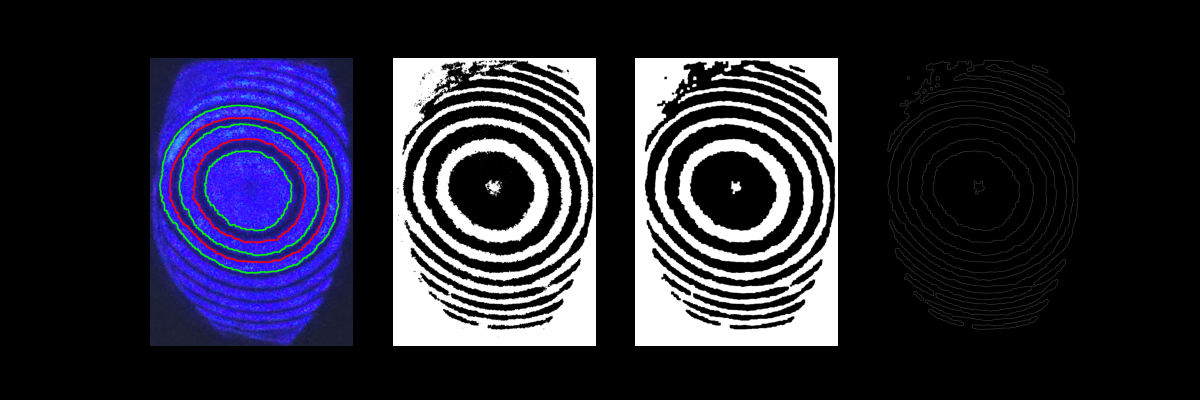

In [18]:
# 读取视频文件并加载前50帧到内存中
video_path = "真实场景.mp4"
frame_number = 42
frame = read_frame(video_path, frame_number)
images = process_frame(frame, (13, 13))
display_images(images)